# Quantum walk


## Thoughts
- p0,....p8
- probabilities:
    - p0->p0 = 0,5 = q
    - p0->p1 = 0,5 = p
    - p1->p0 = 0,5 = p

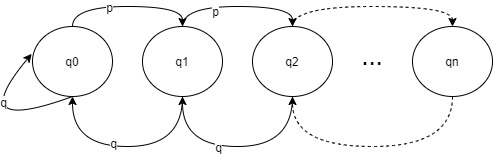

### Example:
- try max number N = 6, and see for ending in q4, stopping in
- P(0, N) = 0
- P(1, N) = 0
- P(2, N) = 0
- P(3, N) = 0
- P(4, N) = $ p^4 $ = 1/16
- P(5, N) = $ qp^4 $ = 1/32
- P(6, N) = $ qqp^4 + pqp^4 + ppqp^3 + p^3qp^2 $ = 1/64 + 1/64 + 1/64 + 1/64 = 4/64 = 1/16

- overall probability to end in q3:
  -> $ \sum _{i=0} ^ {N} P(i, N) $

### Possible Variants
1) End when reaching wanted final state (<=N)
2) Only check if on End (== N) ended in wanted state

#### Check variant 2
- so we search $ P(X_n=x) $ with n=6 and x=4
- number turns left is l with probability q = (1-p) and number of turns right is r with probability p
- n = l+r
- x = 4 = r-l
- $ P(X_n=x=r-l) =  {n \choose k} p^k (1-p)^{n-k} $
search for r,l fullfilling conditions (r-l=3 and l+r=6) -> only for r=5 and l=1:
r=5, l=1: $ P(X_{6}=4) = {6 \choose 5} p^5 (1-p)^1 = 6 p^{6} = 0,09375 $

- Reference: https://de.wikipedia.org/wiki/Random_Walk

### try this with python (classic)

In [1]:
#imports
import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
def perform_walk(init_state, end_state, num_walks):
    state = init_state
    coin_value = 0

    for toss in range(num_walks):
        rand_val = random.random()
        coin = 0
        if rand_val < 0.5:
            coin = 0
        else:
            coin = 1
        
        if coin == 1:
            state += 1
        else:
            if state > 0:
                state -= 1
        #print(coin, state)
        #if state == end_state:
        #    break
            
    return toss, state

In [3]:
num_iterations = 10000

num_tosses_max = 6
state = 0
end_state = 4

data = {}

for iter in range(num_iterations):
    nr_walks, tmp_state = perform_walk (state, end_state, num_tosses_max)
    if tmp_state in data.keys():
        data[tmp_state] = data[tmp_state]+1
    else:
        data[tmp_state] = 1
    
print(data)
    

{2: 2403, 1: 2364, 4: 858, 0: 3118, 3: 933, 6: 168, 5: 156}


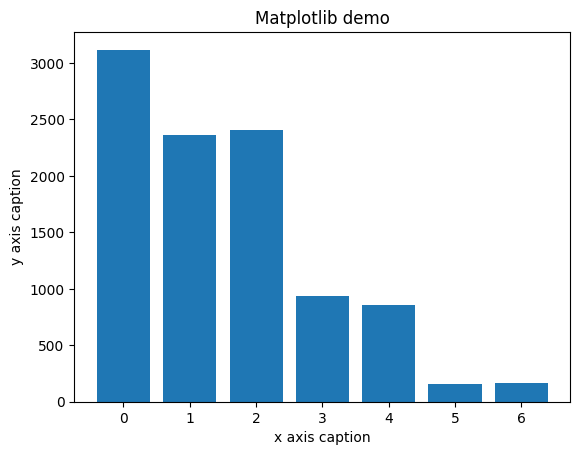

In [4]:
plt.title("Matplotlib demo") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.bar(data.keys(),data.values(), align='center') 
plt.show()

In [5]:
print("probability to reach state 4 with 6 walks is: ", data[end_state]/num_iterations)

probability to reach state 4 with 6 walks is:  0.0858


### Result
estimated result is same as expected/calculated

## now try the quantum way (easy)

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.tools.visualization import plot_histogram

In [7]:
num_shots = 1024
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=num_shots)
num_walks = 6
num_endstate = 4

C:\Users\maussner\AppData\Local\Temp\ipykernel_1264\703237904.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=num_shots)


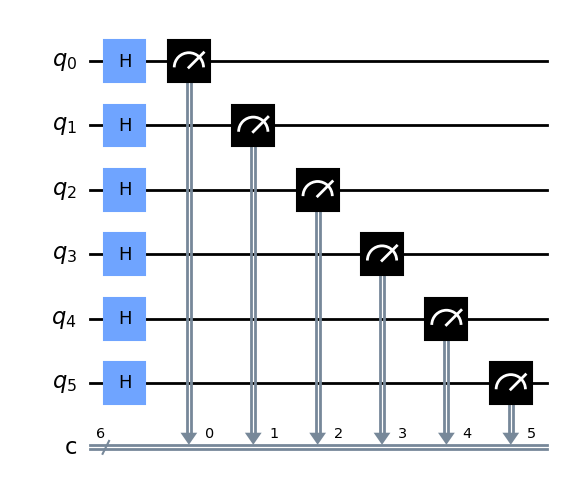

In [8]:
qc = QuantumCircuit(num_walks, num_walks)
# preparation with hadamard
for i in range(num_walks):
    qc.h(i)
#measure output
qc.measure(range(num_walks), range(num_walks))
qc.draw('mpl')

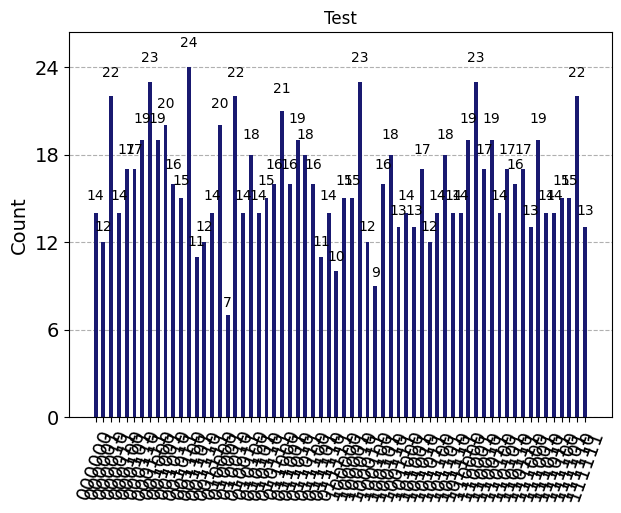

In [9]:
result = quantum_instance.execute(qc)
plot_histogram(result.get_counts(), color='midnightblue', title="Test")

In [10]:
# capture results that we want
probability = 0.0

r = (num_walks+num_endstate)//2

for key in result.get_counts().keys():
    if key.count("1") == r:
        probability += result.get_counts()[key]
    
probability = probability / num_shots

print(probability)
        

0.08984375


### Result: around 0.9 almost 0.09375 -> :-)

## now try the quantum way (better)

- Create a circuit that uses n qubits with hadamard for coin tosses of probability 1/2
- create subsircuit that detects number of "1" and "0" and outputs 1 to $ q_{n+1} $ if num(1)-num(0) == 4 and 0 else
- measure $ q_{n+1} $

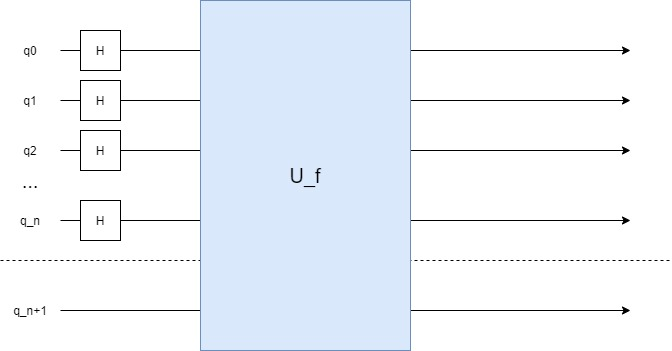

In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions import UnitaryGate

from itertools import permutations
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [12]:
num_shots = 10000
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=num_shots)
num_walks = 6
num_endstate = 4

C:\Users\maussner\AppData\Local\Temp\ipykernel_1264\1354720165.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=num_shots)


In [13]:
#get list of possible states
def get_permutations(num_q, num_endstate):
    if num_endstate >= num_q:
        print("Error: Endstate cannot be reached")
    # create permutations
    # creats list with (1) and (0)
    # calculate number of ones from parameters n = r+l, r-l=endstate -> 2r=n+endstate
    r = (num_q-1+num_endstate)//2
    
    basis_list = []
    for i in range(num_q-1):
        if i < r:
            basis_list.append(1)
        else:
            basis_list.append(0)
    perm = permutations(basis_list)
    
    #remove duplicates
    perm = list(dict.fromkeys(perm))
    #print permutations
    #for i in list(perm):
    #    print (i)
        
    return perm

In [14]:
#calculate needed ancillas
def get_num_ancilla(perm):
    return len(list(perm))+1

In [15]:
#define our U_f
def create_uf(num_q, num_endstate, perm):       
    print(num_q, " ", num_endstate)
    
    matrix = np.zeros((2**num_q, 2**num_q), dtype=float)
    # just to begin with identity
    for i in range(2**num_q):
        matrix[i][i]=1
    #print(matrix)
    
    # now manipulate the matrix

    # now manipulate this matrix to set q(num_q)=1 when state matches perms
    # caution: 00 is represented as (1,0,0,0), 01 = (0,1,0,0), 10 = (0,0,2,0), 11 = (0,0,0,1) 
    qr = QuantumRegister(num_walks+1)
    num_ancilla = get_num_ancilla(perm)
    print("Additional needed ancillas: ", num_ancilla)
    ancilla = QuantumRegister(num_ancilla)
    circuit = QuantumCircuit(qr, ancilla)
    #for n=2, x = 1
    list_perm = list(perm)
    
    #create min-terms
    for idx_perm in range(len(list(perm))):
        perm_elem = list_perm[idx_perm]
        #print("Now constructing for perm: ", perm_elem)
        for index in range(len(perm_elem)):
            if perm_elem[index] == 1:
                pass
            else:
                if perm_elem[index] == 0:
                    circuit.x(qr[index])
                else:
                    print("Error: value not expected, should be either 0 or 1")
        circuit.mcx(qr[0:num_walks], ancilla[idx_perm]) 
        #cleanup x-operators
        for index in range(len(perm_elem)):
            if perm_elem[index] == 1:
                pass
            else:
                if perm_elem[index] == 0:
                    circuit.x(qr[index])
                else:
                    print("Error: value not expected, should be either 0 or 1")
        circuit.barrier()
    
    #or - minterms
    for idx in range(len(list(perm))):
        circuit.x(ancilla[idx])
        
    ancilla_list = []
    for idx in range(len(list(perm))):
        ancilla_list.append(ancilla[idx])
    circuit.mcx(ancilla_list, ancilla[num_ancilla-1])
    #cleanup x-operators
    for idx in range(len(list(perm))):
        circuit.x(ancilla[idx])
    circuit.x(ancilla[num_ancilla-1])
    
    circuit.barrier()
    #entangle output bit to result
    circuit.cx(ancilla[num_ancilla-1], qr[num_walks])
    
    return circuit

In [16]:
perm = get_permutations(num_walks+1, num_endstate)
num_ancilla = get_num_ancilla(perm)

In [17]:
qc = QuantumCircuit((num_walks+1+num_ancilla), 1)
# preparation with hadamard
for i in range(num_walks):
    qc.h(i)
    
#now append u_f
qc.barrier()
qc.append(create_uf(num_walks+1, num_endstate, perm), qc.qubits[:])
qc.barrier()
#measure output
qc.measure(num_walks, 0)

#decomposed_circ = qc.decompose() # Does not modify original circuit
#decomposed_circ.draw('mpl')

7   4
Additional needed ancillas:  7


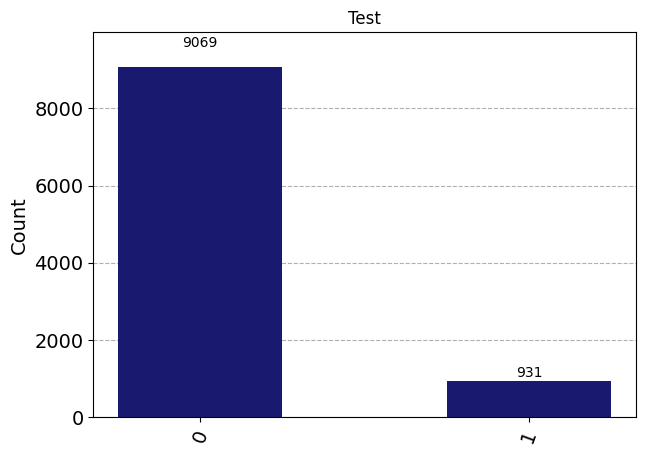

In [18]:
result = quantum_instance.execute(qc)
plot_histogram(result.get_counts(), color='midnightblue', title="Test")

In [19]:
if "1" in result.get_counts().keys():
    print(result.get_counts()["1"]/num_shots)

0.0931


In [20]:
result.get_counts()

{'1': 931, '0': 9069}

### Result: around 0.931 almost 0.09375 -> :-)